In [1]:
import os
os.chdir("..")

In [2]:
import pandas as pd
import plotly.express as px

from src.preprocess import preprocess_spacy as preprocessor
from src.preprocess import translate_google as translator

## Read dataset

In [3]:
claim_df = pd.read_csv("/home/agusriscos/verifiable-phrase-detection/data/raw_data_with_language.csv")

In [4]:
print("Number of documents:", claim_df.shape[0])

Number of documents: 15000


In [5]:
claim_df.dtypes

text                              object
language                          object
language_detection_confidence    float64
claim                              int64
dtype: object

## Missing values

In [6]:
for column in claim_df.columns:
    print("Column \"{0}\" has {1} missing values".format(column, claim_df[column].isna().sum()))

Column "text" has 0 missing values
Column "language" has 0 missing values
Column "language_detection_confidence" has 0 missing values
Column "claim" has 0 missing values


## Target variable

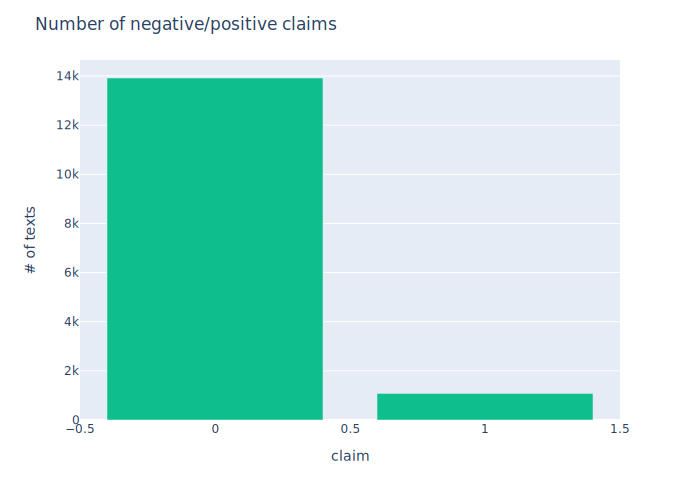

In [7]:
label_count = claim_df["claim"].value_counts().reset_index()
fig = px.bar(label_count, x="index", y="claim")
fig.update_traces(marker_color="#0ebf8c")
fig.update_layout(title="Number of negative/positive claims", xaxis_title="claim", yaxis_title="# of texts")
fig.show("svg")

## Word analysis

### Words after simple tokenization

In [8]:
claim_pipeline = preprocessor.load_processing_pipeline()

In [9]:
# Count words after simple tokenization (removing punctuation)
claim_df["num_words"] = claim_df["text"].apply(
    lambda x: len(preprocessor.tokenize(claim_pipeline, x, with_punctuation=False))
)

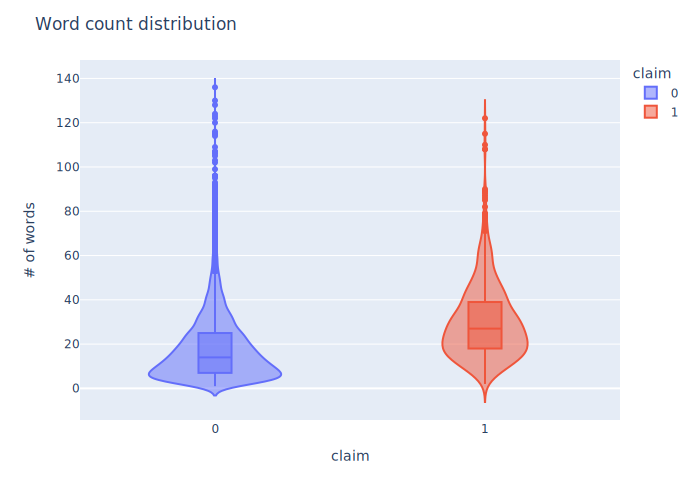

In [10]:
fig = px.violin(claim_df, x="claim", y="num_words", color="claim", box=True)
fig.update_layout(title="Word count distribution", yaxis_title="# of words")
fig.show("svg")

### Significant words after text normalization

<strong>Pasos en la normalización</strong>:
 - Tokenización
 - Quitar stop words y signos de puntuación
 - Lematización  
 
 <strong>Reglas</strong>:
 - No se quitan los valores numéricos (dos, 30...) para intentar detectar frases que expresen cantidad. Ejemplo: "El paro en España ha subido un 20%"
 - No se lematizan los verbos para intentar detectar predicciones. Ejemplo: "España tendrá uno de los 'rebotes' del PIB más grandes del mundo"
 - No se quitan los pronombres (yo, ellos, nosotros...) para intentar detectar frases basadas en experiencias personales. Ejemplo: "Yo hoy me he levantado a las 7 de la mañana"

In [11]:
claim_df["num_significant_words"] = claim_df["text"].apply(
    lambda x: len(set(preprocessor.filter_significant_words(claim_pipeline, x)))
)

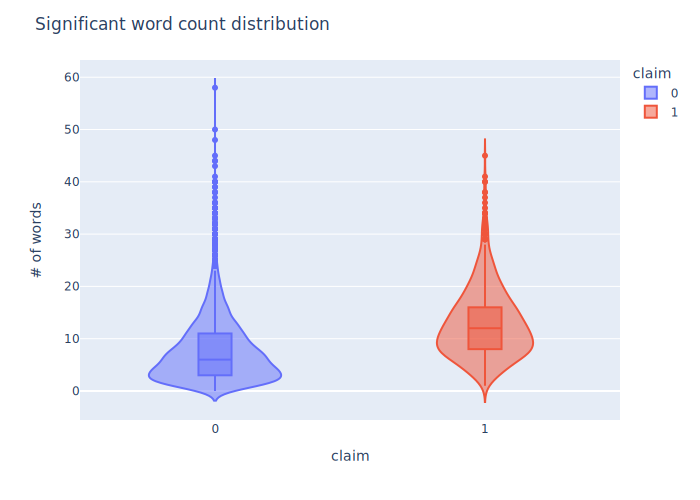

In [12]:
fig = px.violin(claim_df, x="claim", y="num_significant_words", color="claim", box=True)
fig.update_layout(title="Significant word count distribution", yaxis_title="# of words")
fig.show("svg")

In [13]:
claim_df[["num_words", "num_significant_words"]].describe().drop(["count"]).apply(lambda x: round(x, 2))

num_words  num_significant_words
mean      19.03                   7.99
std       15.27                   6.11
min        1.00                   0.00
25%        8.00                   3.00
50%       15.00                   7.00
75%       26.00                  11.00
max      136.00                  58.00

In [26]:
# Positive claims with few significant words
pos_claim_with_few_sigwords = claim_df.loc[(claim_df["num_significant_words"] <= 1) & (claim_df["claim"] == 1)]
print("{} positive claims with few significant words\n".format(
    pos_claim_with_few_sigwords.shape[0]))

dummy_df = pos_claim_with_few_sigwords.apply(
    lambda x: print(x["text"], round(x["language_detection_confidence"], 2)), axis=1
)

2 positive claims with few significant words

La ciudadanía. 1.0
Son de las más modernas. 1.0


### Language analysis

In [16]:
language_iso_list = list(claim_df["language"].unique())
language_list = translator.get_language_names(language_iso_list)
print("Language list:", ", ".join(language_list))

Language list: Spanish, Catalan, Galician, Portuguese, Somali, Italian, Undetermined, English, Romanian, Polish, Danish, French, Indonesian, Swedish, Latvian, Japanese, Hindi, Finnish, Lithuanian, Malagasy


In [17]:
print("{}% of texts whose language has been perfectly detected".format(
    round(claim_df.loc[claim_df["language_detection_confidence"] == 1].shape[0]/claim_df.shape[0] * 100, 2)
))

96.63% of texts whose language has been perfectly detected


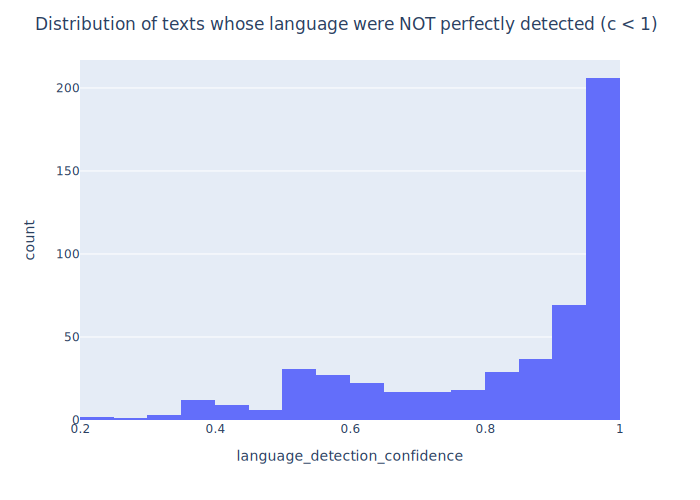

In [18]:
not_well_langdet_df = claim_df.loc[claim_df["language_detection_confidence"] < 0.8]
print("Number of documents with very low language detection confidence (c < 0.8):", not_well_langdet_df.shape[0])# Distribution of text whose language has NOT been perfectly detected (confidence < 1)
langdet_confidence_distribution = claim_df.loc[claim_df["language_detection_confidence"] != 1]
fig = px.histogram(langdet_confidence_distribution, x="language_detection_confidence")
fig.update_layout(title="Distribution of texts whose language were NOT perfectly detected (c < 1)")
fig.show('svg')

In [27]:
not_well_langdet_df = claim_df.loc[claim_df["language_detection_confidence"] < 0.8]
print("Number of documents with very low language detection confidence (c < 0.8): {}\n".format(
    not_well_langdet_df.shape[0]))
dummy_df = not_well_langdet_df.sample(10).apply(
    lambda x: print(x["text"], round(x["language_detection_confidence"], 2)), axis=1
)

Number of documents with very low language detection confidence (c < 0.8): 165

No nos confundamos. 0.58
Oye. 0.67
Mentira. 0.57
de tal manera. 0.77
Como precisamente nos estaba contando Ruth. 0.74
Éramos conscientes. 0.62
Entre onte martes mañana jueves está previsto se isten 6t perdón 65000 primeros 2es o grupo de 50 50 novenos ose mesmo estbamos administrar una segunda 12 a 50000 personas de edades superiores de tal chaito que ose mesmo superaremos la cifra de 500000 galegos inmunizados con doble dosis. 0.6
Por tanto, esta ciudad de administrativa de San Caetano da ose un paso importante licitando a remodelación completa de un dos edificios que data de 1975. 0.52
Por tanto sentémonos a dialogar, a conversar. 0.6
Menos mal. 0.69
